In [182]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 

from glob import glob 
import os 
import cv2

# File Paths

In [177]:
main_directory = 'flowers/flowers/flower_photos/'

train_path = os.path.join(main_directory, 'train')
test_path = os.path.join(main_directory, 'test')

In [186]:
classes = glob(os.path.join(train_path, '*'))
K = len(classes)
K

5

In [179]:
train_img = glob(train_path + '/*/*.jpg')
test_img = glob(test_path + '/*/*.jpg')

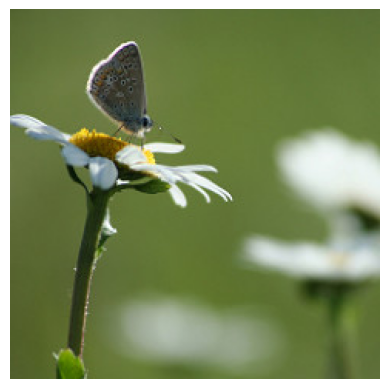

In [160]:
## Random image plotting for testing 

plt.imshow(tf.keras.preprocessing.image.load_img(np.random.choice(test_img)))
plt.axis('Off')
plt.show();

# Data Augmentation

In [181]:
INPUT_SHAPE = [224, 224]

gen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=.2,
    height_shift_range=.2,
    vertical_flip=True,
    rotation_range=.2,
    zoom_range=.2,
    shear_range=.2
)
train_path, test_path

('flowers/flowers/flower_photos/train', 'flowers/flowers/flower_photos/test')

In [162]:
batch_size = 64

train_gen = gen.flow_from_directory(
    train_path,    
    target_size=INPUT_SHAPE,
    batch_size=64,
    shuffle=True
)

test_gen = gen.flow_from_directory(
    test_path,
    target_size=INPUT_SHAPE,
    batch_size=batch_size
)

Found 3540 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


# Model Preparation

In [163]:
ptm = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE + [3],
    pooling='avg'
)
ptm.trainable = False

In [164]:
# Functional approach for model creation 
x = tf.keras.layers.Flatten()(ptm.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(K, activation='softmax')(x)

In [165]:
model = tf.keras.models.Model(inputs=ptm.input, outputs=x)

In [166]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

# Model Compilation and training

In [167]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [169]:
r = model.fit(train_gen, validation_data=test_gen, steps_per_epoch=len(train_gen), validation_steps=len(test_gen), epochs=15)

Epoch 1/15
56/56 [==============================] - 81s 1s/step - loss: 0.3406 - accuracy: 0.8833 - val_loss: 1.2529 - val_accuracy: 0.7000
Epoch 2/15
56/56 [==============================] - 73s 1s/step - loss: 0.3756 - accuracy: 0.8836 - val_loss: 1.1345 - val_accuracy: 0.8000
Epoch 3/15
56/56 [==============================] - 73s 1s/step - loss: 0.3175 - accuracy: 0.8904 - val_loss: 1.0607 - val_accuracy: 0.7400
Epoch 4/15
56/56 [==============================] - 41s 729ms/step - loss: 0.2602 - accuracy: 0.9110 - val_loss: 1.2656 - val_accuracy: 0.8000
Epoch 5/15
56/56 [==============================] - 38s 674ms/step - loss: 0.2641 - accuracy: 0.9105 - val_loss: 1.3454 - val_accuracy: 0.7400
Epoch 6/15
56/56 [==============================] - 40s 709ms/step - loss: 0.3261 - accuracy: 0.8966 - val_loss: 1.2109 - val_accuracy: 0.8800
Epoch 7/15
56/56 [==============================] - 42s 748ms/step - loss: 0.3085 - accuracy: 0.8994 - val_loss: 1.5904 - val_accuracy: 0.7400
Epoch 8/

In [171]:
def pllot(v1, v2):
    plt.plot(r.history[v1], label=v1)
    plt.plot(r.history[v2], label=v2)
    plt.grid()
    plt.legend()
    plt.show();

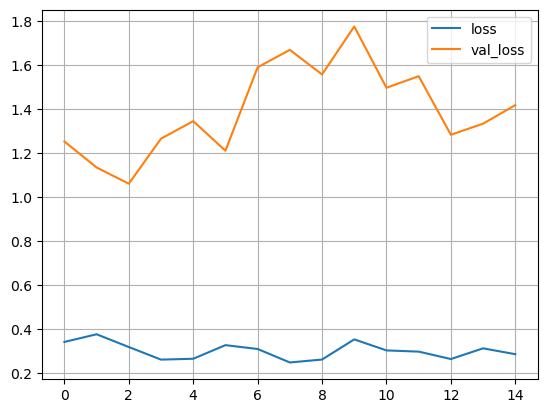

In [172]:
pllot('loss', 'val_loss')

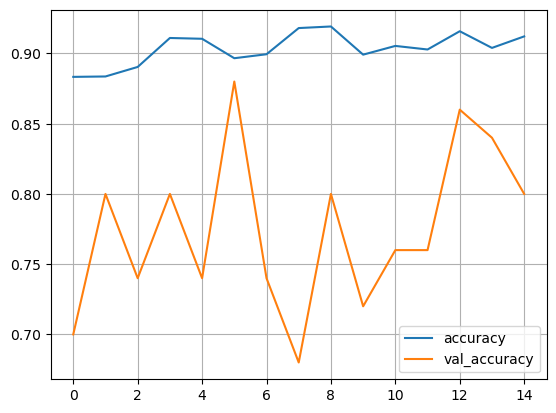

In [173]:
pllot('accuracy', 'val_accuracy')

# Model Prediction

In [260]:
validation_path = os.path.join(main_directory, 'validation')
class_flowers = os.listdir(train_path)
validation_image = glob(validation_path + '/*/*.jpg')

In [265]:
def make_predictions(test_idx, prediction_index):
    for i in range(min(1, len(test_idx))):
        image = cv2.imread(str(test_idx))
        image_resize = cv2.resize(image, (224, 224))
        image = np.expand_dims(image_resize, axis=0)

        pred = model.predict(image)
        pred_class = class_flowers[np.argmax(pred)]

        plt.imshow(cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB))
        plt.title(f'Predicted class: {pred_class}, True class: {prediction_index}')
        plt.axis('off')
        plt.show();

1/1 [==============================] - 0s 37ms/step


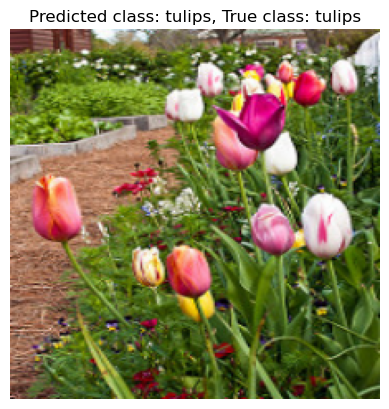

1/1 [==============================] - 0s 32ms/step


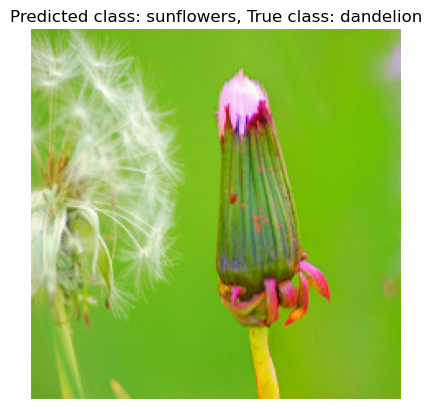

1/1 [==============================] - 0s 53ms/step


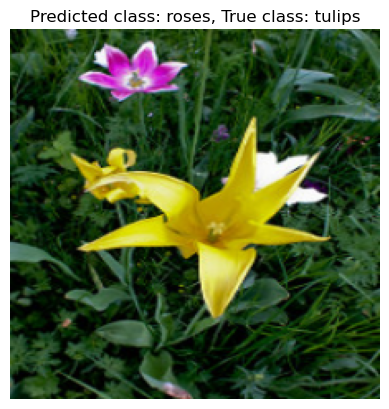

1/1 [==============================] - 0s 55ms/step


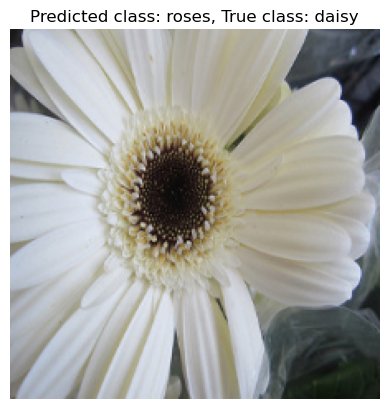

In [268]:
for i in range(0, 4):
    pred_idx = np.random.choice(validation_image)
    make_predictions(test_idx=pred_idx, prediction_index=pred_idx.split('/')[4])

# The model is still not getting the majority of images right, so the model requires more optimization as it is overfitting a bit.